In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
proj_range = torch.load('proj_range.pt')
proj_mask = torch.load('proj_mask.pt')
pred_np = torch.load('pred_np.pt')

In [18]:
pred_np.clip(0, 118)

array([13, 13, 13, ...,  9,  9,  9])

In [20]:
pred_np.shape

(124668,)

In [26]:
sum(pred_np > 1)

3826

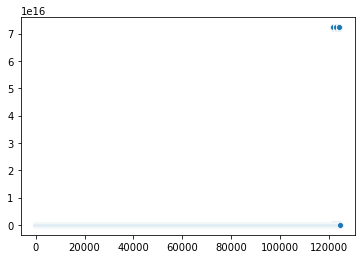

In [8]:
sns.scatterplot(np.arange(len(pred_np)), pred_np)

In [3]:
class MedianPool2d(nn.Module):
    """ Median pool (usable as median filter when stride=1) module.
    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=3, stride=1, padding=0, same=True):
        super(MedianPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding
    
    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd, 
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        return x

In [4]:
medpool3 = MedianPool2d()
medpool5 = MedianPool2d(kernel_size=5)
medpool7 = MedianPool2d(kernel_size=7)
medpool13 = MedianPool2d(kernel_size=13)
medpool29 = MedianPool2d(kernel_size=29)
def fill_step(tensor, mask, medpool):
    eps = 1e-6
    H, W = tensor.shape[0], tensor.shape[1]
    tensor = tensor * mask # clear the tensor
    
    # apply median filter then combine
    median = tensor.clone()
    median = median + medpool(median.unsqueeze(0).unsqueeze(0)).squeeze() * torch.logical_not(mask)
    mask = median.abs() > eps
    return median, mask

torch.Size([64, 512])


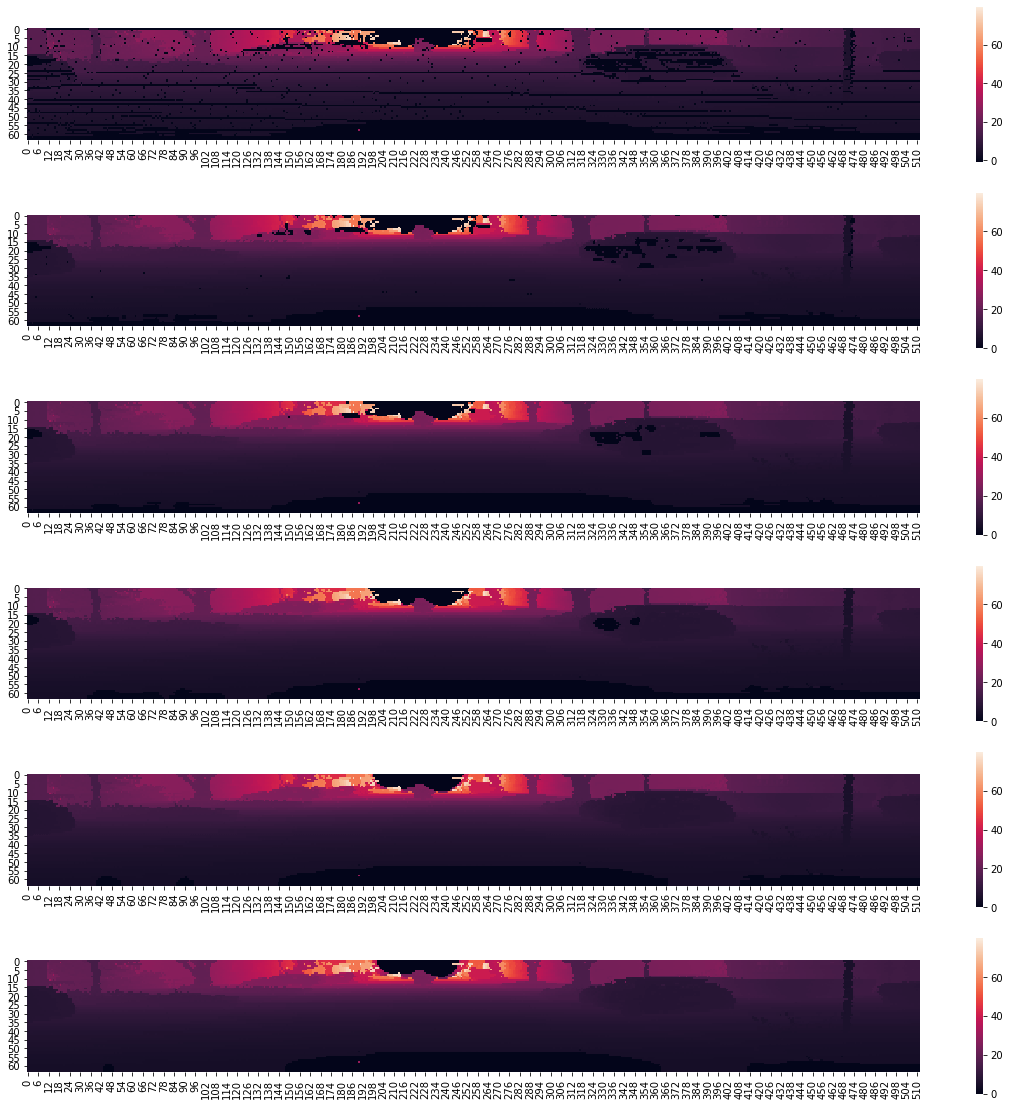

In [7]:
x = proj_range.clone()
mask = proj_mask.clone()
print(x.shape)
plt.figure(figsize=(20, 20))
plt.subplot(6, 1, 1)
sns.heatmap(x, square=True)
plt.subplot(6, 1, 2)
x, mask = fill_step(x, mask, medpool3)
sns.heatmap(x, square=True)
plt.subplot(6, 1, 3)
x, mask = fill_step(x, mask, medpool5)
sns.heatmap(x, square=True)
plt.subplot(6, 1, 4)
x, mask = fill_step(x, mask, medpool7)
sns.heatmap(x, square=True)
plt.subplot(6, 1, 5)
x, mask = fill_step(x, mask, medpool13)
sns.heatmap(x, square=True)
plt.subplot(6, 1, 6)
x, mask = fill_step(x, mask, medpool13)
sns.heatmap(x, square=True)

In [8]:
import vispy
vispy.test()

Skipping example test: Cannot test examples unless in vispy git directory
Running line endings check... 
Passed

Skipping flake8 test, flake8 not installed
Passed

Testing succeeded (0 failed, ['pyqt4', 'pyqt5', 'pyside', 'pyside2', 'pyglet', 'glfw', 'sdl2', 'wx', 'egl', 'osmesa', 'ipynb_webgl', '_test', 'nobackend', 'examples'] skipped) in 0.586 seconds
